Stock Price Predictor Using Technical Indicators and LSTM Deep Learning Model.

Predicting Stock Prices is proven to be a difficult task that remains out of the possibility due to market volatility and hidden factors. In the following project, I will attempt to build and evaluate a Deep Learning Model using Python with technical indicators as features to predict Proctor & Gamble's (P&G) Closing Price. 
The goal is to build a model, assess its accuracy relatively; where I will use the following critereas to evaluate success:
1. Have a more accurate prediction than the baseline model, where it will only use the closing price to predict its next movement.
2. Achieve a minimal error rate of below 2% between the training and the testing dataset.
3. Implement the model to forecast the next 5 days of closing price, retaining the same relative error rate as the testing set.

Model Selection

There is a multitude of model selection available to predict stock prices. These choices include Random Forest, Autoregressive Integrated Moving Average (ARIMA), etc. I've decided to implement a Long-Short-Term Memory (LSTM) Neural Network Model because stock price are time-dependent and exhibits temporal patterns that a tradional models may struggle to capture. Unlike standard feed-forward networks or tree-based models, LSTM are designed to learn from sequences of data, allowing the model to use historical context over a fixed lookback window to make predictions. This makes LSTMs well-suited for financial time series tasks where lagged effects and momentum play a key role. 

About the Stock

Since there are a multitude of factors impacting stock prices, predicting a high-volatility stock can prove challenging as major fluctuations create nonstationary patterns, leading models to overfit on recent high prices and causing it to struggle to predict on turning points. Proctor and Gamble has shown relative stability throughout its lifetime, therefore will serve as a baseline for this project to predict and build a strong pipeline over. 

Data Collection

Historical stock price data will be collected through the yfinance library, which will fetch the stock data directly from the Yahoo Finance API. The data will be collected over its entire lifetime available in the archive, from January 1st 2002, to the present. Data will also include:
• Open - The start of day price
• High - The highest price reached throughout the day.
• Low - The minimum price reached throughout the day.
• Close - The end of day price
• Volume - The number of shares that were traded on that day

In [3]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler  

from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

In [4]:
pg = yf.download("pg", start="2002-01-01", end = '2025-06-25')
pg.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,PG,PG,PG,PG,PG
Date,,,,,
2002-01-02,21.139929,21.139929,20.616715,20.849255,6261600
2002-01-03,20.936468,21.028955,20.772633,20.957607,5216800
2002-01-04,20.730350,21.007813,20.664288,20.939108,6181400
2002-01-07,20.492523,20.740916,20.373610,20.672213,6412200
2002-01-08,20.548014,20.640500,20.421173,20.492522,4009800


Feature Engineering 

To add context to the model, we will implement features to add context to predictions and understand its behavior. I've evaluated further features, tested the complete model to the reduced model to indicate which features are useful and which are not, resulting in the following:

1. Relative Strength Index (RSI)
- The RSI tells us whether a stock is overbought or oversold, which can cause price reversal.

2. Exponential Moving Average (EMA)
- Short-term (EMA20) and long-term (EMA100) moving averages provide the model with understanding of both quick price changes and long-term trends.

3. Volume Price Change 
- Since volume only indicates the trading frequency of a stock that day, it is also the biggest indicator of movement since higher movement indicates bigger fluctuation in trading. However, selling/buying volume is a level 2 information, I will tweak it such that the volume of that day is also 

In terms of features, there are a multitude of variables that are used to monitor the movements of stock price. 

In [5]:
pg['RSI', 'PG'] = RSIIndicator(pg['Close', 'PG'], window=14).rsi()
pg['Vol_PriceChange', 'PG'] = pg['Volume', 'PG'] * pg['Close','PG'].pct_change()
pg['EMA20', 'PG'] = EMAIndicator(pg['Close', 'PG'], window=20).ema_indicator()
pg['EMA100', 'PG'] = EMAIndicator(pg['Close', 'PG'], window=100).ema_indicator()
pg = pg.dropna()
pg.head()

Price,Close,High,Low,Open,Volume,RSI,Vol_PriceChange,EMA20,EMA100
Ticker,PG,PG,PG,PG,PG,PG,PG,PG,PG
Date,,,,,,,,,
2002-05-24,24.065733,24.340358,23.916421,24.196380,4765200,44.582448,-57891.421898,24.420821,23.279933
2002-05-28,23.465834,24.156396,23.329853,24.156396,7467800,36.089674,-186153.812184,24.329869,23.283614
2002-05-29,23.201864,23.663130,23.196533,23.423165,10684000,33.101579,-120185.344296,24.222440,23.281995
2002-05-30,23.663132,23.713791,23.036559,23.220530,6607400,42.119880,131359.215712,24.169173,23.289542
2002-05-31,23.876434,24.124397,23.721790,23.791114,6218400,45.761106,56053.483554,24.141293,23.301164


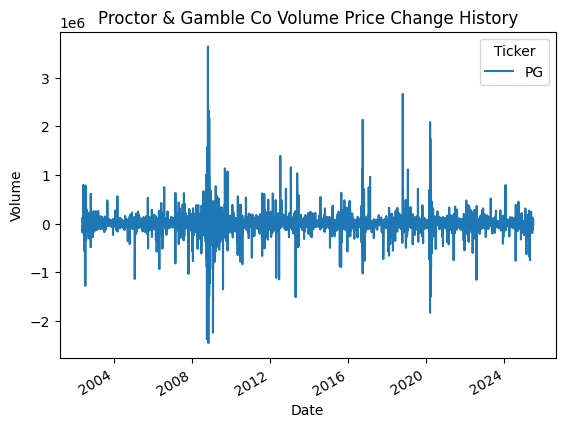

In [6]:
pg.plot.line(y = "Vol_PriceChange", use_index = True)
plt.title("Proctor & Gamble Co Volume Price Change History")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.show()

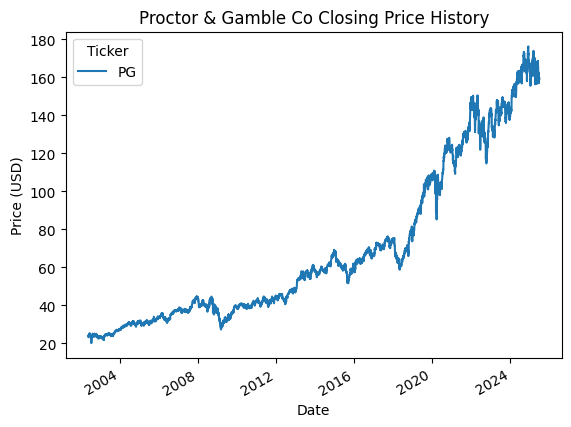

In [7]:
pg.plot.line(y = "Close", use_index = True)
plt.title("Proctor & Gamble Co Closing Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

In [8]:
#creating a target variable and the predictor variables
close_price = pg.filter([( 'Close', 'PG')])
vol_price_change = pg.filter([( 'Vol_PriceChange', 'PG')])
rsi_index = pg.filter([( 'RSI', 'PG')])
ema_20 = pg.filter([('EMA20', 'PG')])
ema_100 = pg.filter([('EMA100', 'PG')])
y = close_price.values
x1 = vol_price_change.values
x2 = rsi_index.values
x3 = ema_20.values
x4 = ema_100.values
training_data_len = math.ceil(len(y) * .7)

In [9]:
#scalar transforming the data
closed_y = pg[['Close']].values
closed_x1 = pg[['Vol_PriceChange']].values
closed_x2 = pg[['RSI']].values
scaler_y = MinMaxScaler(feature_range=(0, 1))
scaler_x1 = MinMaxScaler(feature_range=(-1, 1))
scaler_x2 = MinMaxScaler(feature_range=(0, 1))
closed_y = scaler_y.fit_transform(closed_y)
closed_x1 = scaler_x1.fit_transform(closed_x1)
closed_x2 = scaler_x2.fit_transform(closed_x2)

In [10]:
X_all = np.hstack((closed_x1, closed_x2, closed_y))
#split into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(X_all)):
    x_train.append(X_all[i-60:i])       
    y_train.append(X_all[i, 2]) #grabs 'Close' as the target


To capture roughly the quarterly cycle, we will use 60 trading days as a proxy for a quarter as it roughly corresponds to three months of trading days.

In [11]:
#Conver the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1,1)

In [12]:
#Build the LSTM model, adding Dropout layers to prevent overfitting
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 3)))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(25))
model.add(Dense(1)) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
#Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop])    

Epoch 1/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0122 - val_loss: 0.0041
Epoch 2/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.4270e-04 - val_loss: 4.0757e-04
Epoch 3/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 5.5377e-04 - val_loss: 4.8392e-04
Epoch 4/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 5.4837e-04 - val_loss: 4.1992e-04
Epoch 5/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 4.7814e-04 - val_loss: 4.1953e-04
Epoch 6/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.3809e-04 - val_loss: 5.2639e-04
Epoch 7/100
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.4487e-04 - val_loss: 0.0010


In [15]:
train_predictions = model.predict(x_train)
train_predictions = scaler_y.inverse_transform(train_predictions)
train_predictions

180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


array([[ 24.637522],
       [ 24.538956],
       [ 24.422688],
       ...,
       [159.51007 ],
       [158.919   ],
       [158.5089  ]], dtype=float32)

In [16]:
y_values = scaler_y.inverse_transform(y_train)

In [17]:
test_rmse = np.sqrt(mean_squared_error(y_values, train_predictions))
test_rmse

np.float64(1.8666195142864812)

In [18]:
test_error = (test_rmse/y_values.mean()) * 100
test_error

np.float64(2.6662420884507467)

In [19]:
#Create the testing dataset
test_data = X_all[training_data_len - 60:, :]
x_test = []
y_test = y[training_data_len:, :]       
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i])

In [20]:
#Convert the data to a numpy array
x_test = np.array(x_test)

In [21]:
#Get models predicted price values
predictions = model.predict(x_test)
closed_predictions = scaler_y.inverse_transform(predictions)
#closed_y_test = scaler.inverse_transform(y_test)
closed_predictions

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[ 65.72663],
       [ 65.79144],
       [ 65.82902],
       ...,
       [159.51007],
       [158.919  ],
       [158.5089 ]], dtype=float32)

In [22]:
y_test

array([[ 65.82249451],
       [ 65.78066254],
       [ 65.63853455],
       ...,
       [157.99949646],
       [159.93624878],
       [159.27081299]])

In [23]:
train_rmse = np.sqrt(mean_squared_error(y_test, closed_predictions))
train_rmse

np.float64(2.899648966104091)

In [24]:
error_rate = (train_rmse/y_test.mean()) * 100
error_rate

np.float64(2.2819679555821177)

/var/folders/l7/n6_49wq50y5chmy25lb24n3m0000gn/T/ipykernel_95911/4278679868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closed_predictions


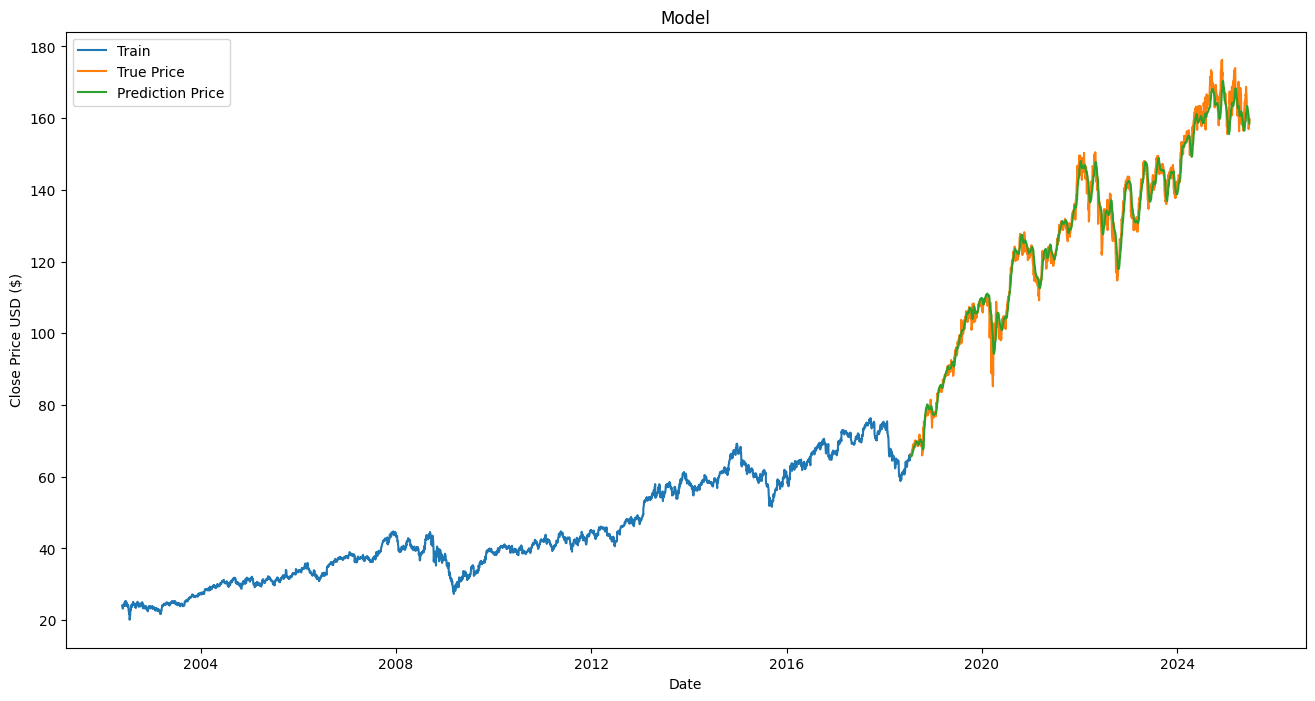

In [25]:
#plot the data
train = pg[:training_data_len]
valid = pg[training_data_len:]
valid['Predictions'] = closed_predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='True Price')
plt.plot(valid['Predictions'], label='Prediction Price')
plt.legend()
plt.show()